In [95]:
import pandas as pd
from pymongo import MongoClient
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

import plotly.express as px
from datetime import datetime
from dateutil.relativedelta import relativedelta

cf.set_config_file(theme='ggplot', sharing='public', offline=True)
plotly.io.renderers.default= 'png'


def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

db = _connect_mongo(host='localhost', port=27017, username=None, password=None, db='OpenRoadDB')

KPI = db.kpi
ENGINE = db.engine
ENGINE_HISTORY = db.engine_history


run_id_meta = {
    '3m6YeNAegnji': 'Pickup Optimal',
    # 'mPfqMXf8SKra': 'Revenue Optimal Old',
    'HIRxOWvYN1hb': 'Revenue Optimal',
    # 'oNHquhS3gcoU': 'Service Optimal old',
    'lQKlTodJMtIh': 'Service Optimal',
    # 'TyJszk5F2yxO': 'Compromise ServiceBias 0',
    # 'BA8sJJUNH3Nm': 'Compromise ServiceBias 1',
    'qiU4avUNYsNB': 'Compromise ServiceBias',
    'qO7HWJEAEngT': 'Compromise ServiceBias R1.2P1.2S1.0',


} # Comfort Data Set Sampled (10p 06d) Svc Dist 2,



In [96]:
# cursor = db.engine_history.find({
#             'run_id': 'xSx0cwH3JgTH',
#         },
#         projection={ '_id': 0, 'online_params.realtime_reverse_pickup_time_step': 1},
#         sort=[('online_params.realtime_reverse_pickup_time_step', -1)]
#     )

# list(cursor)

In [97]:
def get_pivot(collection, run_id_meta, metric):
    cursor = collection.find({
            'run_id': {'$in': [k for k, _ in run_id_meta.items()]},
            'metric': metric
        },
        projection={ '_id': 0, 'run_id': 1, 'sim_clock': 1, 'value': 1,},
        sort=[('sim_clock', 1)]
    )

    metric_df = pd.DataFrame(list(cursor))

    metric_pivot = pd.pivot_table(metric_df, 
                                  index='sim_clock', 
                                  columns='run_id', 
                                  values='value').rename(columns=run_id_meta)
    cumulative_pivot = metric_pivot.cumsum()

    return metric_pivot, cumulative_pivot



def get_engine_perf_local(collection, run_id_list):
    cursor = collection.find({
            'run_id': {'$in': run_id_list},
        },
        projection={ '_id': 0, 'online_params': 1, 'sim_clock': 1, 'runtime_performance': 1,},
        sort=[('sim_clock', 1)]
    )

    metric_df = pd.DataFrame(list(cursor))
    metric_df = pd.concat([metric_df.drop(['online_params'], axis=1), metric_df['online_params'].apply(pd.Series)], axis=1)
    metric_df = pd.concat([metric_df.drop(['runtime_performance'], axis=1), metric_df['runtime_performance'].apply(pd.Series)], axis=1)

    metric_df

    return metric_df



sum_metric = [
    'num_served', 
    'num_cancelled',
    'revenue', 
    'wait_time_pickup',
    'service_score'
]
avg_metric_byServed = [
    'revenue', 
    'wait_time_pickup',
    # 'wait_time_driver_confirm', 
    # 'wait_time_assignment',
    'service_score'
]



In [98]:

gamma = 1.2
# gamma = 0.9
# Sum(Revenue) / num_steps / Scale_factor
# Scale_factor as needed for normalization
# Data from Greedy_revenue Scenario
target_revenue = 76524.41 * gamma / 960 / 1
# target_revenue = 26325.43 * 1.5 / 960 / 1
print(f"{target_revenue=}")

# Sum(pickup_budget) - Sum(pickup_time) / num_steps / Scale_factor
# Scale_factor as needed for normalization
# Data from Greedy_pickup Scenario
# Budget Computed by max Pickup (600) * Num_Served 
target_pickup_time = ((600*5227) - (2396940)) * gamma / 960 / 10
print(f"{target_pickup_time=}")

# Sum(service_score) / num_steps / Scale_factor
# Scale_factor as needed for normalization
# Data from Greedy_service Scenario
target_service = 401944.0 * 1.0 / 960 / 5
print(f"{target_service=}")





target_revenue=95.6555125
target_pickup_time=92.4075
target_service=83.73833333333333


In [99]:
real_target_revenue = 74477 / 960
real_target_pickup_time = 2391900 / 960
real_target_service = 399731 / 960


print(f"{real_target_revenue=}")
print(f"{real_target_pickup_time=}")
print(f"{real_target_service=}")



real_target_revenue=77.58020833333333
real_target_pickup_time=2491.5625
real_target_service=416.38645833333334


In [100]:
# cursor = KPI.find({
#         'run_id': {'$in': [k for k, _ in run_id_meta.items()]},
#     },
#     projection={ '_id': 0, 'run_id': 1, 'sim_clock': 1, 'value': 1, 'metric': 1,},
#     sort=[('sim_clock', 1)]
# )

# metric_df = pd.DataFrame(list(cursor))



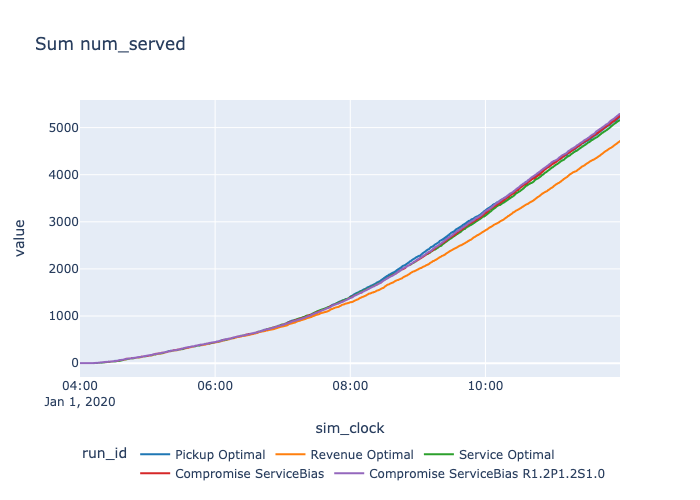

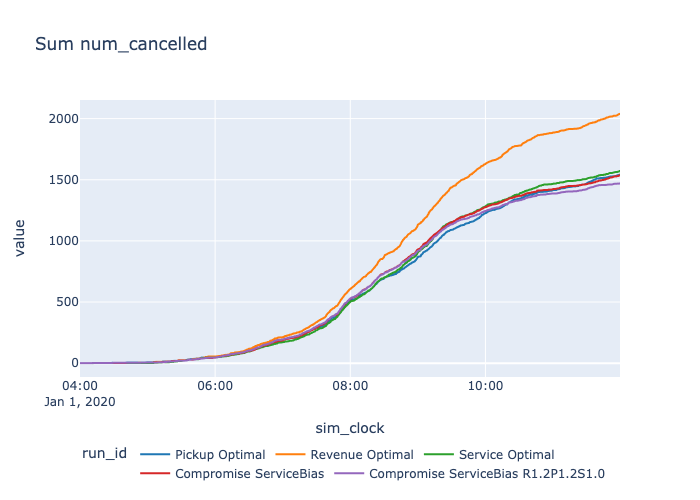

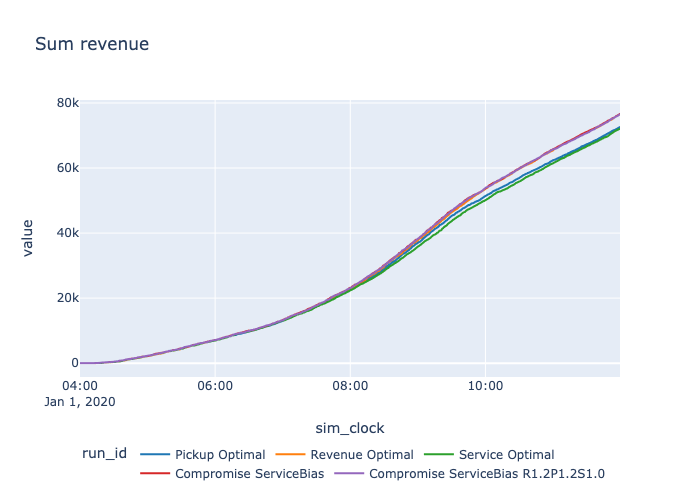

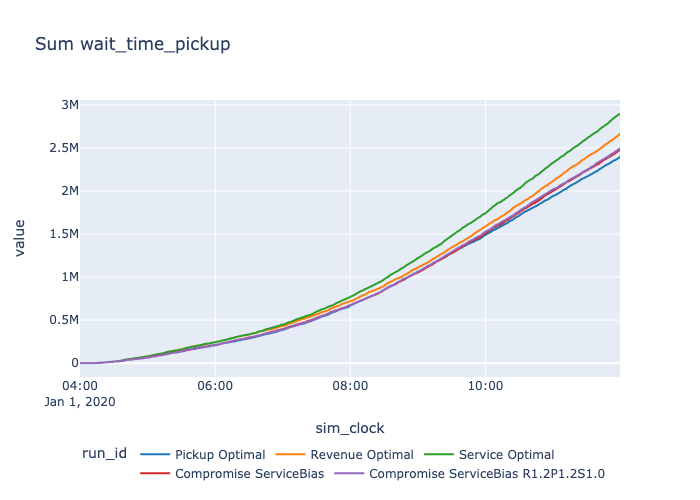

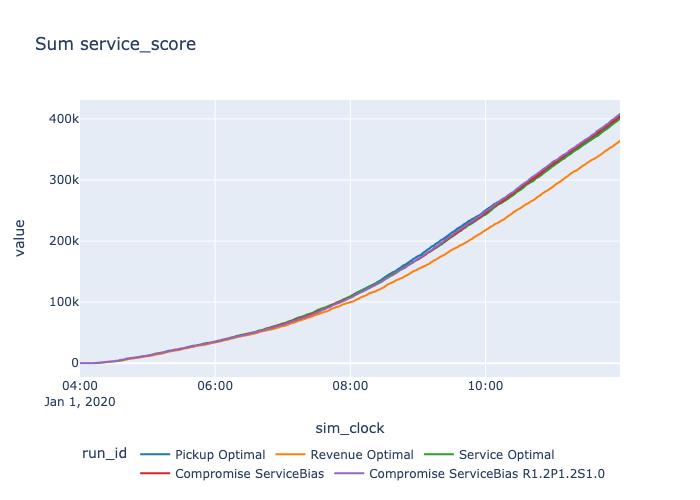

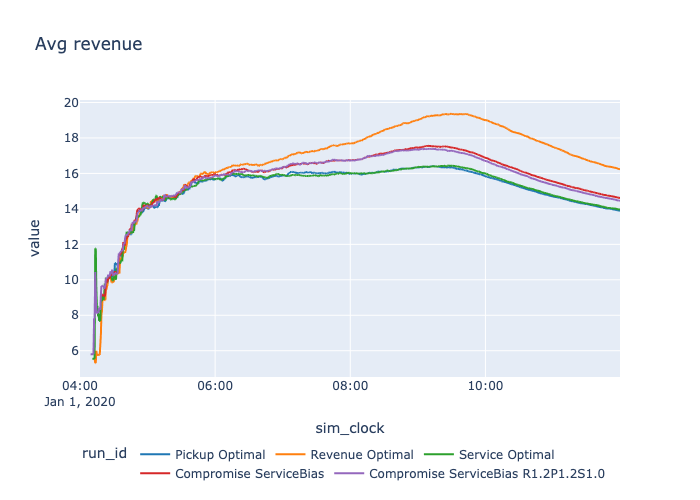

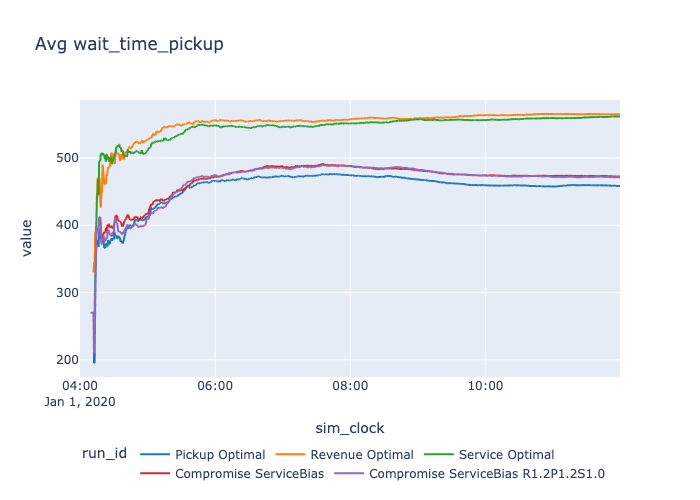

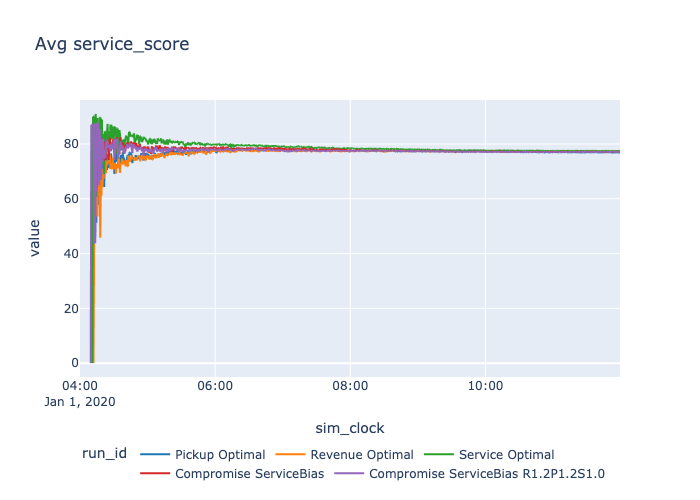

In [110]:
from IPython.display import Image

for m in sum_metric:
    metric_pivot, cum_pivot = get_pivot(KPI, run_id_meta, m)
    # print(cum_pivot.tail(1))

    fig = px.line(cum_pivot, title=f"Sum {m}",
                 color_discrete_sequence=px.colors.qualitative.D3,
                 category_orders={'run_id': [v for _, v in run_id_meta.items()]}) 

    # fig = px.bar(cum_pivot[cum_pivot.index=='2020-01-01 10:59:00'], title=f"Sum {m}",
    #          color_discrete_sequence=px.colors.qualitative.D3,
    #          category_orders={'run_id': [v for _, v in run_id_meta.items()]},
    #         orientation='h',
    #             barmode='group',
    #         ) 

    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.4,
    ))
    fig.show()


served_pivot, cum_served_pivot = get_pivot(KPI, run_id_meta, 'num_served')
for m in avg_metric_byServed:
    metric_pivot, cum_pivot = get_pivot(KPI, run_id_meta, m)
    metric_pivot = metric_pivot / served_pivot
    cum_pivot = cum_pivot / cum_served_pivot
    # print(cum_pivot.tail(1))

    fig = px.line(cum_pivot, title=f"Avg {m}",
                 color_discrete_sequence=px.colors.qualitative.D3,
                 category_orders={'run_id': [v for _, v in run_id_meta.items()]}) 
    # fig = px.bar(cum_pivot[cum_pivot.index=='2020-01-01 11:59:00'], title=f"Avg {m}",
    #              color_discrete_sequence=px.colors.qualitative.D3,
    #              category_orders={'run_id': [v for _, v in run_id_meta.items()]},
    #         orientation='h',
    #             barmode='group',
    #              ) 

    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.4,
    ))
    fig.show()



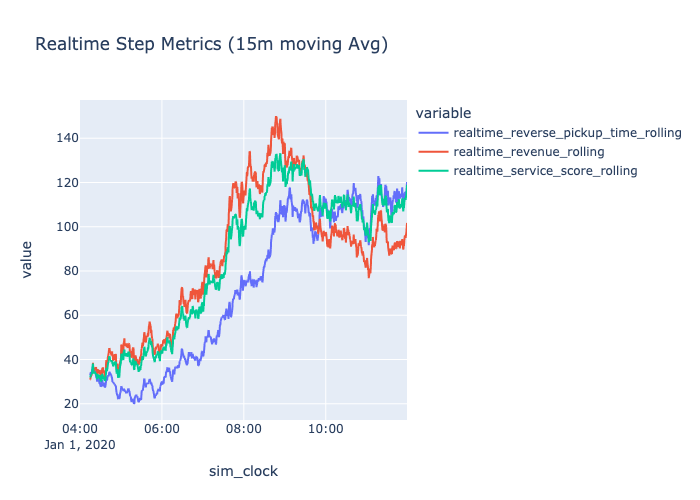

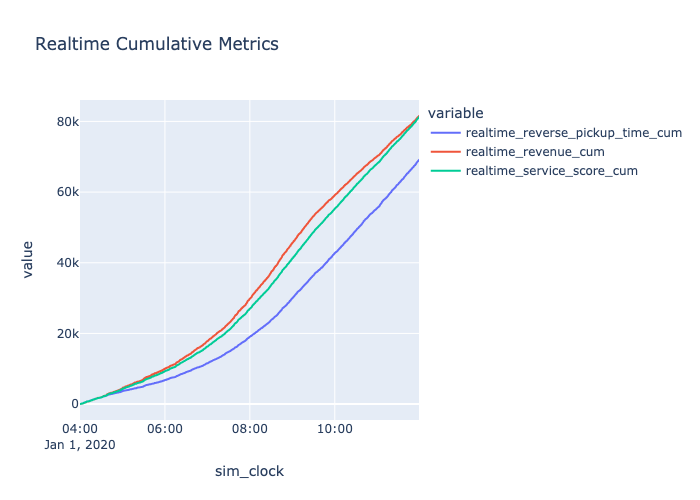

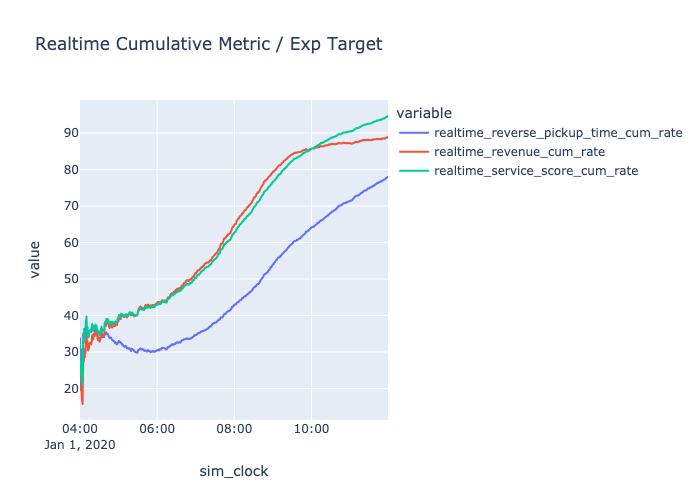

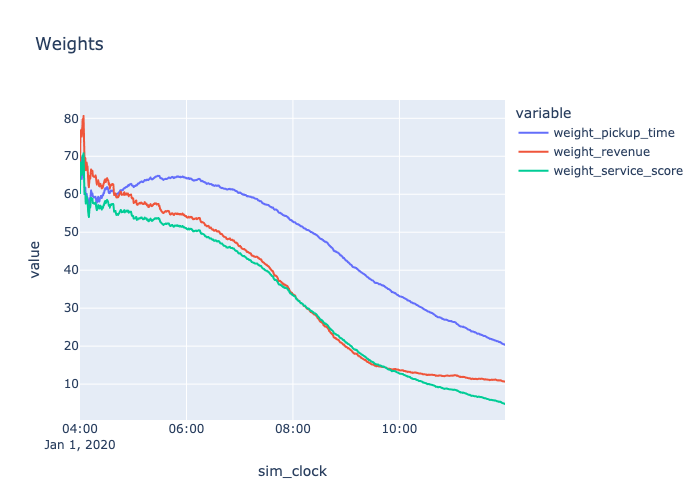

In [111]:
# engine_df = get_engine_perf_local(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Pickup Optimal'])
# engine_df = get_engine_perf_local(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Revenue Optimal'])
# engine_df = get_engine_perf_local(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Service Optimal'])
# engine_df = get_engine_perf_local(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Compromise'])
# engine_df = get_engine_perf_local(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Compromise R1.5 P1.2 S1.2'])
# engine_df = get_engine_perf_local(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Compromise ServiceBias'])
engine_df = get_engine_perf_local(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Compromise ServiceBias R1.2P1.2S1.0'])





engine_df['realtime_reverse_pickup_time_cum_rate'] = 100* engine_df['realtime_reverse_pickup_time_cum'] / engine_df['exp_target_reverse_pickup_time']
engine_df['realtime_revenue_cum_rate'] = 100* engine_df['realtime_revenue_cum'] / engine_df['exp_target_revenue']
engine_df['realtime_service_score_cum_rate'] = 100* engine_df['realtime_service_score_cum'] / engine_df['exp_target_service_score']

engine_df[['realtime_reverse_pickup_time_rolling',
         'realtime_revenue_rolling', 
         'realtime_service_score_rolling']] = engine_df[['realtime_reverse_pickup_time_step',
                                                 'realtime_revenue_step', 
                                                 'realtime_service_score_step']].rolling(30).mean()
# fig = px.line(engine_df, x='sim_clock', 
#               y=['realtime_reverse_pickup_time_rate','realtime_revenue_rate', 'realtime_service_score_rate',
#                 ],
#               title='Compromise') #, labels = run_id_meta)
# fig.show()
fig = px.line(engine_df, 
              x='sim_clock', 
              y=['realtime_reverse_pickup_time_rolling',
                 'realtime_revenue_rolling', 
                 'realtime_service_score_rolling',
                ],
              title='Realtime Step Metrics (15m moving Avg)') #, labels = run_id_meta)
fig.show()

fig = px.line(engine_df, x='sim_clock', 
              y=['realtime_reverse_pickup_time_cum',
                 'realtime_revenue_cum',
                 'realtime_service_score_cum',
                ],
              title='Realtime Cumulative Metrics') #, labels = run_id_meta)
fig.show()

fig = px.line(engine_df, x='sim_clock', 
              y=['realtime_reverse_pickup_time_cum_rate',
                 'realtime_revenue_cum_rate', 
                 'realtime_service_score_cum_rate',
                ],
              title='Realtime Cumulative Metric / Exp Target') #, labels = run_id_meta)
fig.show()

fig = px.line(engine_df, x='sim_clock', 
              y=['weight_pickup_time',
                 'weight_revenue', 
                 'weight_service_score',
                ],
              title='Weights') #, labels = run_id_meta)
fig.show()





In [11]:
engine_df.columns

Index(['sim_clock', 'realtime_revenue_cum', 'realtime_reverse_pickup_time_cum',
       'realtime_service_score_cum', 'weight_pickup_time', 'weight_revenue',
       'weight_service_score', 'exp_target_reverse_pickup_time',
       'exp_target_revenue', 'exp_target_service_score',
       'realtime_reverse_pickup_time_step', 'realtime_revenue_step',
       'realtime_service_score_step', 'run_time', 'num_drivers',
       'num_passenger_trips', 'result',
       'realtime_reverse_pickup_time_cum_rate', 'realtime_revenue_cum_rate',
       'realtime_service_score_cum_rate',
       'realtime_reverse_pickup_time_rolling', 'realtime_revenue_rolling',
       'realtime_service_score_rolling'],
      dtype='object')

NameError: name 'get_engine_perf' is not defined